## Setup

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter
import torchtext
from torchtext.vocab import Vocab
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import seaborn as sns


from nltk.tokenize import word_tokenize

pd.set_option('display.max_colwidth', None)

## Dataset

In [17]:
data = pd.read_csv("/content/drive/Shareddrives/Grupo Turing/Áreas de Foco/NLP/Aulas Internas/Redes Siamesas/train.csv")

In [18]:
data.dropna(inplace=True)

In [19]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [20]:
print('Número de pares positivos: ', data[data['is_duplicate']==1].shape[0])
print('Número de pares negativos: ', data[data['is_duplicate']==0].shape[0])

Número de pares positivos:  149263
Número de pares negativos:  255024


In [21]:
data_ = data
data = data.sample(n=50000).reset_index()

In [ ]:
NEG_POS_RATIO = 6

positive_data = data[data['is_duplicate']==1]

dataset = []

for row in tqdm(positive_data.itertuples(index=False)):
  anchor = row[4]
  positive = row[5]
  curr_ratio = 0
  while curr_ratio < NEG_POS_RATIO:
    aux_data =  data.loc[(~data['question1'].isin([anchor, positive])) & (~data['question2'].isin([anchor, positive]))]
    random_idx = np.random.randint(low=0, high=aux_data.shape[0])
    aux_row = data.iloc[random_idx]
    negative = aux_row['question2']
    curr_ratio+=1
    dataset.append({'anchor': anchor, 'positive': positive, 'negative': negative})

dataset_df = pd.DataFrame(dataset)
dataset_df.to_csv("custom_quora.csv")

18423it [16:36, 18.48it/s]


In [ ]:
dataset_df.head(10)

,anchor,positive,negative
0,What could be the basic purpose of life?,What according to YOU is the purpose of life?,How can the rate of mass transfer via thermal pump in a closed system be calculated?
1,What could be the basic purpose of life?,What according to YOU is the purpose of life?,What are some of the unbelievable facts in science?
2,What could be the basic purpose of life?,What according to YOU is the purpose of life?,What should I do to stop comparing myself or my life to other people who are better than me?
3,What could be the basic purpose of life?,What according to YOU is the purpose of life?,Is circumcision allowed in Islam?
4,What could be the basic purpose of life?,What according to YOU is the purpose of life?,Is there a question that will never have an answer?
5,What could be the basic purpose of life?,What according to YOU is the purpose of life?,What motivates people to study psychology?
6,What are the different ways to masturbate?,What different ways can I masturbate?,What is the easiest way to make money online without spending a lot of time or money?
7,What are the different ways to masturbate?,What different ways can I masturbate?,What lessons can Muslims learn from atheists?
8,What are the different ways to masturbate?,What different ways can I masturbate?,"Could I live in Beverly Hills, CA on $130,000 a year?"
9,What are the different ways to masturbate?,What different ways can I masturbate?,"I am in class 9. If i want to crack IIT JEE, then which book would be good for chemistry in class 10?"


In [ ]:
train, test = train_test_split(dataset_df, test_size=0.15)
train.to_csv("custom_quora_train.csv", index=False)
test.to_csv("custom_quora_test.csv", index=False)

## Rede recorrente simples

In [ ]:
text_series = set(list(train['anchor'].append([train['negative'], train['positive']])))
text_series = map(word_tokenize, text_series)
text_series = list(sum(text_series, []))
counter = Counter(text_series)

In [ ]:
en_vocab = Vocab(counter,max_size=2000, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

In [ ]:
def data_process(dataset_df):
  data = []
  for i, row in dataset_df.iterrows():
    anchor_tensor_ = torch.tensor([en_vocab[token] for token in word_tokenize(row['anchor'])],
                            dtype=torch.long)
    positive_tensor_ = torch.tensor([en_vocab[token] for token in word_tokenize(row['positive'])],
                            dtype=torch.long)
    negative_tensor_ = torch.tensor([en_vocab[token] for token in word_tokenize(row['negative'])],
                            dtype=torch.long)
    data.append((anchor_tensor_, positive_tensor_, negative_tensor_))
  return data

train_data = data_process(train)
test_data = data_process(test)

In [ ]:
BATCH_SIZE = 128
PAD_IDX = en_vocab['<pad>']
BOS_IDX = en_vocab['<bos>']
EOS_IDX = en_vocab['<eos>']

def generate_batch(data_batch):
  anchor_batch, pos_batch, neg_batch = [], [], []
  for (anchor_item, pos_item, neg_item) in data_batch:
    anc_tensor = torch.cat([torch.tensor([BOS_IDX]), anchor_item, torch.tensor([EOS_IDX])], dim=0)
    pos_tensor = torch.cat([torch.tensor([BOS_IDX]), pos_item, torch.tensor([EOS_IDX])], dim=0)
    neg_tensor = torch.cat([torch.tensor([BOS_IDX]), neg_item, torch.tensor([EOS_IDX])], dim=0)
    anchor_batch.append(anc_tensor)
    pos_batch.append(pos_tensor)
    neg_batch.append(neg_tensor)
  l = int(len(pos_batch))
  pad_list = anchor_batch + pos_batch + neg_batch
  pads =  pad_sequence(pad_list, padding_value=PAD_IDX)
  anchor_batch  = pads[:,:l]
  pos_batch = pads[:,l:2*l]
  neg_batch = pads[:,2*l:3*l]
  return anchor_batch, pos_batch, neg_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

In [ ]:
class Siamese(nn.Module):
    def __init__(self, vocab_size, d_model, hidden_size):
        super(Siamese, self).__init__()
        #layers
        self.embedding = nn.Embedding(vocab_size,d_model)
        self.rnn = nn.GRU(d_model, hidden_size)

    def forward(self,src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        outputs = torch.mean(outputs, dim=1) 
        embeds = torch.tanh(outputs)
        return embeds

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
INPUT_DIM = len(en_vocab)
EMB_DIM = 64
HIDDENSIZE = 128

model = Siamese(INPUT_DIM, EMB_DIM, HIDDENSIZE).to(device)

optimizer = optim.Adam(model.parameters())
triplet_loss = nn.TripletMarginLoss()
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 202,752 trainable parameters


In [ ]:
def train(model: nn.Module,
          iterator: torch.utils.data.DataLoader,
          optimizer: optim.Optimizer,
          triplet_loss: nn.Module,
          clip: float):
    model.train()
    epoch_loss = 0
    for _, (anchor,positive, negative) in enumerate(iterator):
        anchor,positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad()
        anchor_embedding = model(anchor)
        positive_embedding = model(positive)
        negative_embedding = model(negative)
        loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)


def evaluate(model: nn.Module,
             iterator: torch.utils.data.DataLoader,
             triplet_loss: nn.Module):

    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for _, (anchor,positive, negative) in enumerate(iterator):
            anchor,positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            anchor_embedding = model(anchor)
            positive_embedding = model(positive)
            negative_embedding = model(negative)
            loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [ ]:
N_EPOCHS = 30
CLIP = 1
for epoch in range(1,N_EPOCHS+1):
    train_loss = train(model, train_iter, optimizer, triplet_loss, CLIP)

    print(f'epoch: {epoch}\tTrain Loss: {train_loss:.3f}')

test_loss = evaluate(model, test_iter, triplet_loss)

print(f'Test Loss: {test_loss:.3f}')

epoch: 1	Train Loss: 0.165
epoch: 2	Train Loss: 0.090
epoch: 3	Train Loss: 0.074
epoch: 4	Train Loss: 0.070
epoch: 5	Train Loss: 0.052
epoch: 6	Train Loss: 0.055
epoch: 7	Train Loss: 0.046
epoch: 8	Train Loss: 0.047
epoch: 9	Train Loss: 0.042
epoch: 10	Train Loss: 0.041
epoch: 11	Train Loss: 0.040
epoch: 12	Train Loss: 0.040
epoch: 13	Train Loss: 0.040
epoch: 14	Train Loss: 0.038
epoch: 15	Train Loss: 0.038
epoch: 16	Train Loss: 0.038
epoch: 17	Train Loss: 0.037
epoch: 18	Train Loss: 0.035
epoch: 19	Train Loss: 0.037
epoch: 20	Train Loss: 0.036
epoch: 21	Train Loss: 0.035
epoch: 22	Train Loss: 0.035
epoch: 23	Train Loss: 0.034
epoch: 24	Train Loss: 0.035
epoch: 25	Train Loss: 0.038
epoch: 26	Train Loss: 0.035
epoch: 27	Train Loss: 0.035
epoch: 28	Train Loss: 0.035
epoch: 29	Train Loss: 0.035
epoch: 30	Train Loss: 0.034
Test Loss: 0.034


### Resultados

In [ ]:
def euclidean_distance(x,y):
  return np.linalg.norm(x-y)

def compute_phrases_embs(phrases):
  phrases_processed = []
  for phrase in phrases:
    phrase_tensor = torch.tensor([en_vocab[token] for token in word_tokenize(phrase)],
                              dtype=torch.long)
    phrase_tensor = torch.cat([torch.tensor([BOS_IDX]), phrase_tensor, torch.tensor([EOS_IDX])], dim=0)
    phrases_processed.append(phrase_tensor)
  tensors = pad_sequence(phrases_processed, padding_value=PAD_IDX).T
  embs = model(tensors.to(device))
  return embs

def make_plot_similarity(phrases):
  embeddings = compute_phrases_embs(phrases)
  numpy_embeddings = embeddings.to('cpu').detach().numpy()
  sim_matrix = np.zeros((len(phrases), len(phrases)))
  for i, v1 in enumerate(numpy_embeddings):
    for j, v2 in enumerate(numpy_embeddings):
      sim = euclidean_distance(v1,v2)
      sim_matrix[i,j] = sim
  sns.heatmap(pd.DataFrame(sim_matrix, columns=phrases, index=phrases), annot=True)
  plt.show()

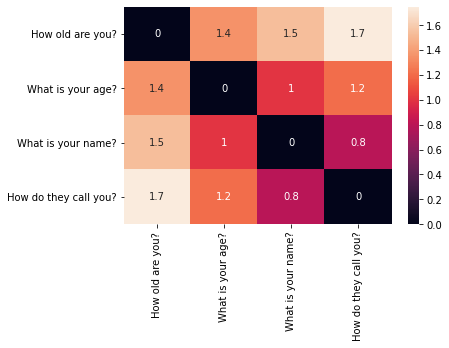

In [ ]:
phrases = ['How old are you?', 'What is your age?', 'What is your name?', 'How do they call you?']
make_plot_similarity(phrases)